In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import seaborn as sns

from Util_Fin import Wind_util
from HRP_config import HRPConfig
from Util_Fin import easy_manager

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2024 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.
Easy Manager is running...


In [2]:
code_list = HRPConfig.CODE_LIST
start_date = HRPConfig.START_DATE
end_date = HRPConfig.END_DATE
chg_freq = HRPConfig.CHG_FREQ

with easy_manager.EasyManager(database = 'macro_data_base') as em:
    price_df_d = em.load_table('daily_asset_price_1')
    price_df_d.set_index('index',inplace=True)
    price_df_d.index = pd.to_datetime(price_df_d.index)
    price_df_d = price_df_d[code_list]


2025-12-10 09:51:03,542 - datadeal_20251210 - INFO - ==================================================
2025-12-10 09:51:03,543 - datadeal_20251210 - INFO - 数据库连接成功: macro_data_base
2025-12-10 09:51:03,550 - time_cal_20251210 - INFO - [Function: load_table started...]
2025-12-10 09:51:03,590 - datadeal_20251210 - INFO - 按列 'index' 升序排序
2025-12-10 09:51:03,659 - datadeal_20251210 - INFO - 成功从表 daily_asset_price_1 加载数据，形状: (5040, 17)
2025-12-10 09:51:03,661 - time_cal_20251210 - INFO - [Function: load_table completed, elapsed time: 0.11s]
2025-12-10 09:51:03,666 - datadeal_20251210 - INFO - 数据库连接已关闭
2025-12-10 09:51:03,666 - datadeal_20251210 - INFO - ==================================================


In [3]:
'''
mark number:
    0: 000300_SH
    1: 000905_SH
    2: CBA00601_CS
    3: CBA02001_CS
    4: 000832_CSI
    5: NH0200_NHF
    6: NH0300_NHF
    7: B_IPE
    8: AU9999_SGE
    # 9: USDCH_FX
'''

'\nmark number:\n    0: 000300_SH\n    1: 000905_SH\n    2: CBA00601_CS\n    3: CBA02001_CS\n    4: 000832_CSI\n    5: NH0200_NHF\n    6: NH0300_NHF\n    7: B_IPE\n    8: AU9999_SGE\n    # 9: USDCH_FX\n'

In [15]:
ret_d = price_df_d.pct_change().dropna()
ret_d_n = ret_d.copy()
ret_d_n.columns = [0,1,2,3,4,5,6,7,8]
rho_g = ret_d_n.corr()
D_g = np.sqrt((1-rho_g)/2)
for i in range(len(D_g)):
    D_g.iloc[i,i] = 0

C:\Users\28054\AppData\Local\Temp\ipykernel_11044\484128722.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_d = price_df_d.pct_change().dropna()


(8, 4)
[[0.         1.         0.34777636 2.        ]
 [2.         3.         0.63943982 2.        ]
 [5.         6.         0.65837082 2.        ]
 [4.         9.         0.67927496 3.        ]
 [7.         8.         0.98362195 2.        ]]


C:\Users\28054\AppData\Local\Temp\ipykernel_11044\1003408634.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(D_g,  method='ward', metric='euclidean')


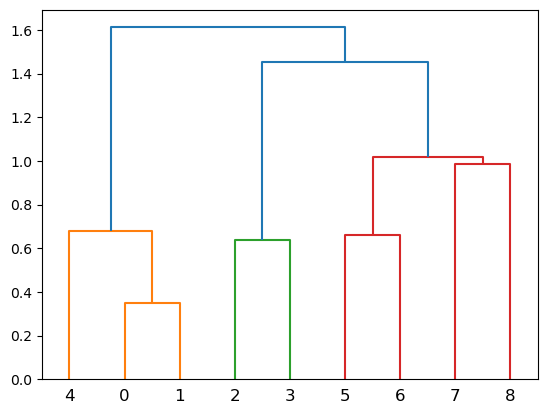

In [16]:
Z = linkage(D_g,  method='ward', metric='euclidean')
print(Z.shape)
print(Z[: 5])

# fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
# # plt.show()
# Z_pd = pd.DataFrame(Z)

In [17]:
Z

array([[ 0.        ,  1.        ,  0.34777636,  2.        ],
       [ 2.        ,  3.        ,  0.63943982,  2.        ],
       [ 5.        ,  6.        ,  0.65837082,  2.        ],
       [ 4.        ,  9.        ,  0.67927496,  3.        ],
       [ 7.        ,  8.        ,  0.98362195,  2.        ],
       [11.        , 13.        ,  1.01707703,  4.        ],
       [10.        , 14.        ,  1.45162439,  6.        ],
       [12.        , 15.        ,  1.61181778,  9.        ]])

In [18]:
#拟对角化
def get_quasi_diag(link):
    
    # sort clustered items by distance
    
    link = link.astype(int)
    
    # get the first and the second item of the last tuple
    sort_ix = pd.Series([link[-1,0], link[-1,1]]) 
    
    # the total num of items is the third item of the last list
    num_items = link[-1, 3]
    
    # if the max of sort_ix is bigger than or equal to the max_items
    while sort_ix.max() >= num_items:
        # assign sort_ix index with 24 x 24
        sort_ix.index = range(0, sort_ix.shape[0]*2, 2) # odd numers as index
        
        df0 = sort_ix[sort_ix >= num_items] # find clusters
        
        # df0 contain even index and cluster index
        i = df0.index
        j = df0.values - num_items # 
        
        sort_ix[i] = link[j,0] # item 1
        
        df0  = pd.Series(link[j, 1], index=i+1)
        
        # sort_ix = sort_ix.append(df0)
        sort_ix = pd.concat([sort_ix, df0])

        sort_ix = sort_ix.sort_index()
        
        sort_ix.index = range(sort_ix.shape[0])
        
    
    return sort_ix.tolist()

In [19]:
sort_ix = get_quasi_diag(Z)
sort_ix

[4, 0, 1, 2, 3, 5, 6, 7, 8]

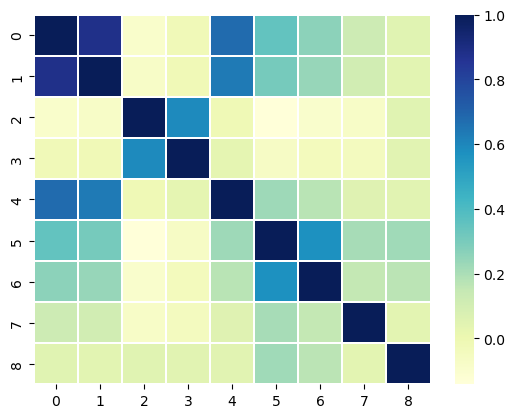

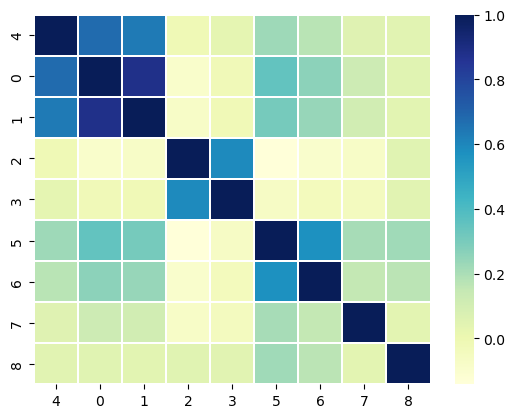

In [20]:
corr_heatmap = sns.heatmap(rho_g, cmap="YlGnBu", linewidths=.2)
plt.show()
corr_heatmap = sns.heatmap(ret_d_n[sort_ix].corr(), cmap="YlGnBu", linewidths=.2)
plt.show()

In [38]:
def get_cluster_var(cov, c_items):
    cov_ = cov.iloc[c_items, c_items] # matrix slice
    # calculate the inversev-variance portfolio
    ivp = 1./np.diag(cov_)
    ivp/=ivp.sum()
    w_ = ivp.reshape(-1,1)
    c_var = np.dot(np.dot(w_.T, cov_), w_)[0,0]
    return c_var
def get_rec_bipart(cov, sort_ix,k=1,mode='sum'):
    expect_sharp = ret_d_n.mean()/ret_d_n.std()
    # compute HRP allocation
    # intialize weights of 1
    w = pd.Series(1, index=sort_ix)
    
    # intialize all items in one cluster
    c_items = [sort_ix]
    while len(c_items) > 0:
        # bisection
        c_items = [i[int(j):int(k)] for i in c_items for j,k in 
                   ((0,len(i)/2),(len(i)/2,len(i))) if len(i)>1]
        
        # now it has 2
        for i in range(0, len(c_items), 2):
            c_items0 = c_items[i] # cluster 1
            c_items1 = c_items[i+1] # cluter 2
            if mode == 'mean':
                b0 = expect_sharp.loc[c_items0].mean()
                b1 = expect_sharp.loc[c_items1].mean()
            elif mode == 'sum':
                b0 = expect_sharp.loc[c_items0].sum()
                b1 = expect_sharp.loc[c_items1].sum()
                
            
            c_var0 = get_cluster_var(cov, c_items0)
            c_var1 = get_cluster_var(cov, c_items1)
            
            alpha = 1 - (c_var0/b0)/(c_var0/b0+c_var1/b1)
            
            w[c_items0] *= alpha
            w[c_items1] *=1-alpha
    return w

In [35]:
#夏普动量
expect_sharp = ret_d_n.mean()/ret_d_n.std()
expect_sharp.loc[[4, 0, 1, 2]]

4    0.027120
0    0.021545
1    0.026943
2    0.115386
dtype: float64

In [39]:
cov = ret_d.cov()
weights = get_rec_bipart(cov, sort_ix)

new_index = [ret_d.columns[i] for i in weights.index]
weights.index = new_index
weights

C:\Users\28054\AppData\Local\Temp\ipykernel_11044\206918738.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.28766882 0.28766882 0.28766882 0.28766882]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[c_items0] *= alpha


000832_CSI     0.000984
000300_SH      0.000370
000905_SH      0.000379
CBA00601_CS    0.285936
CBA02001_CS    0.705898
NH0200_NHF     0.000503
NH0300_NHF     0.001270
B_IPE          0.000223
AU9999_SGE     0.004438
dtype: float64

In [24]:
weights

000832_CSI     0.003333
000300_SH      0.001580
000905_SH      0.002006
CBA00601_CS    0.353225
CBA02001_CS    0.618825
NH0200_NHF     0.004862
NH0300_NHF     0.009673
B_IPE          0.000987
AU9999_SGE     0.005510
dtype: float64